In [7]:
import torch
import sys
import os
import random
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm import tqdm
import pandas as pd
sys.path.append('../../')
import TD3
import utils

sys.path.append('../')
from common import make_env, perform_action, const_disturb_five, const_jitter_force, get_frame_skip_and_timestep, const_disturb_half
from evals import *



In [14]:
def eval_policy_increasing_force_hybrid_reflex(policy, parent_policy, eval_env, max_action, eval_episodes=10,
                                               env_timestep=0.02, frame_skip=1, jit_frames=0, response_rate=0.04,
                                               start_force=0.25, delayed_env=False, parent_steps=2, zero_reflex=False,
                                               fast_eval=False, reflex_threshold=0):

    get_next_disturb = const_disturb_half if fast_eval else const_disturb_five

    avg_reward = 0.
    rewards = []
    steps = []
    avg_angle = 0.
    end_force = 0
    t = 0
    actions = 0
    for _ in range(eval_episodes):
        eval_env.model.opt.gravity[0] = 0
        counter = 0
        disturb = get_next_disturb(1)
        force = start_force * 9.81
        jerk = 0
        jittered_frames = 0
        jittering = False
        jitter_force = 0
        reflex = False
        state, done = eval_env.reset(), False
        child_state = state
        parent_action = eval_env.previous_action
        next_parent_action = parent_action
        total_reward = 0
        while not done:
            # parent action changed every parent-steps. Due to delayed environment, the actual change happens one
            # step before the next action.
            if t % parent_steps == 0:
                next_parent_action = parent_policy.select_action(state).clip(-max_action, max_action)
            elif (t+1) % parent_steps == 0:
                parent_action = next_parent_action
            # do not clip child action since it can go over, its max action should be twice.
            if isinstance(policy, TD3.TD3):
                child_action = policy.select_action(child_state) * (1-zero_reflex)
            else:
                child_action = policy(torch.Tensor(child_state).to(device)).cpu().detach().numpy() * (1-zero_reflex)
            action = (parent_action + child_action).clip(-max_action, max_action)
            if np.all(abs(action - parent_action) < reflex_threshold):
                action = parent_action
                child_action = 0
                if (t + 1) % parent_steps == 0:
                        actions += 1
            else:
                actions += 1
            
            jittering, disturb, counter, jittered_frames, jitter_force, next_state, reward, done, force = perform_action(
                jittering, disturb, counter, response_rate, eval_env, reflex, action, None, frame_skip,
                const_jitter_force, force, env_timestep, jit_frames, jittered_frames, get_next_disturb, jitter_force,
                1, delayed_env)

            total_reward += reward
            avg_angle += abs(next_state[1])
            counter = round(counter, 3)

            if counter == disturb:
                jitter_force, force = const_jitter_force(force)
                eval_env.model.opt.gravity[0] = jitter_force
                jittering = True
                jittered_frames = 0

            child_state = next_state
            state = next_state
            t += 1
            steps.append([parent_action, child_action, action, jitter_force, jittering])
        rewards.append(total_reward)
        avg_reward += total_reward
        end_force += force

    avg_reward /= eval_episodes
    avg_angle /= eval_episodes
    jerk /= t
    avg_actions = actions/eval_episodes

    return avg_reward, avg_angle, jerk, avg_actions, end_force / (9.81 * eval_episodes), rewards, steps

In [15]:
def get_results(dataframe, default_timestep, response_rate, parent_response_rate, env_name, reflex_threshold, jit_duration):
    for seed in tqdm(range(5)):
        torch.manual_seed(seed)
        np.random.seed(seed)

        frame_skip, timestep, jit_frames = get_frame_skip_and_timestep(jit_duration, response_rate,
                                                                       default_timestep) 
        parent_steps = int(parent_response_rate/response_rate)  # Number children steps in on parent step
        time_change_factor = (default_timestep * default_frame_skip) / (timestep * frame_skip)
        env = make_env(env_name, seed, time_change_factor, timestep, frame_skip, delayed_env)
        state_dim = env.observation_space[0].shape[0]
        action_dim = env.action_space.shape[0]
        parent_max_action = float(env.action_space.high[0])
        child_max_action = 2 * parent_max_action
        kwargs = {
            "state_dim": state_dim + action_dim,
            "action_dim": action_dim,
            "max_action": parent_max_action,
            "discount": discount,
            "tau": tau,
            "observation_space": env.observation_space,
            "delayed_env": delayed_env,
            "reflex": False,
        }
        # Initialize policy
            # Target policy smoothing is scaled wrt the action scale
        kwargs["policy_noise"] = policy_noise * parent_max_action
        kwargs["noise_clip"] = noise_clip * parent_max_action
        kwargs["policy_freq"] = policy_freq
        parent_policy = TD3.TD3(**kwargs)
        kwargs["max_action"] = child_max_action
        kwargs["policy_noise"] = policy_noise * child_max_action
        kwargs["noise_clip"] = noise_clip * child_max_action
        policy = TD3.TD3(**kwargs)
        arguments = [policy_name, env_name, seed, parent_response_rate, delayed_env, 'best']
        print(arguments)
        parent_file_name = '_'.join([str(x) for x in arguments])
        parent_policy.load(f"../hybrid/models_paper/{parent_file_name}")
        arguments = ["reflex_train", policy_name, env_name, seed,jit_duration, response_rate, parent_response_rate, 'best']
        file_name = '_'.join([str(x) for x in arguments])
        policy.load(f"../hybrid/models_paper/{file_name}")
        eval_env = make_env(env_name, seed, time_change_factor, timestep, frame_skip, delayed_env)
        eval_env.env.env._max_episode_steps = 1000000
        avg_reward, avg_angle, jerk, avg_actions, end_force, rewards, steps = eval_policy_increasing_force_hybrid_reflex(policy, parent_policy,
                                                                                              eval_env, parent_max_action, 10,
                                                                                              timestep, frame_skip,
                                                                                              jit_frames, response_rate, 0.25,
                                                                                              delayed_env, parent_steps,
                                                                                              True, True, reflex_threshold)
        dataframe.loc[len(dataframe)] = [env_name, avg_reward, seed, avg_actions, reflex_threshold]

In [20]:
default_timesteps = {'InvertedPendulum-v2':0.02, 'Hopper-v2': 0.002, 'Walker2d-v2': 0.002, 'InvertedDoublePendulum-v2':0.01}
default_frame_skips = {'InvertedPendulum-v2':2, 'Hopper-v2': 4, 'Walker2d-v2': 4, 'InvertedDoublePendulum-v2':5}
dataframe = pd.DataFrame(columns=["env", "result", "seed", "actions", "threshold"])

delayed_env = True
policy_name = 'TD3'
discount = 0.99
tau=0.005
policy_freq=2
policy_noise=2
noise_clip=0.5
# # inverted pendulum
# env_name = 'InvertedPendulum-v2'
# response_rate = 0.02
# parent_response_rate = 0.04
# default_timestep = default_timesteps[env_name]
# default_frame_skip = default_frame_skips[env_name]
# jit_duration = 0.02
# reflex_threshold = 4*0.3
# for t in range(21):
#     reflex_threshold = t*0.3
#     print(reflex_threshold)
#     get_results(dataframe, default_timestep, response_rate, parent_response_rate, env_name, reflex_threshold, jit_duration)


# # Hopper
env_name = 'Hopper-v2'
response_rate = 0.004
parent_response_rate = 0.008
default_timestep = default_timesteps[env_name]
default_frame_skip = default_frame_skips[env_name]
jit_duration = 0.004
reflex_threshold = 4*0.1
for t in range(21):
    reflex_threshold = t*0.1
    print(reflex_threshold)
    get_results(dataframe, default_timestep, response_rate, parent_response_rate, env_name, reflex_threshold, jit_duration)
    
    
# # Walker2d
# env_name = 'Walker2d-v2'
# response_rate = 0.004
# parent_response_rate = 0.008
# default_timestep = default_timesteps[env_name]
# default_frame_skip = default_frame_skips[env_name]
# jit_duration = 0.004
# reflex_threshold = 4*0.1
# for t in range(21):
#     reflex_threshold = t*0.1
#     print(reflex_threshold)
#     get_results(dataframe, default_timestep, response_rate, parent_response_rate, env_name, reflex_threshold, jit_duration)

0.0


  0%|                                                                                                       | 0/5 [00:00<?, ?it/s]

['TD3', 'Hopper-v2', 0, 0.008, True, 'best']


 20%|███████████████████                                                                            | 1/5 [00:48<03:12, 48.08s/it]

['TD3', 'Hopper-v2', 1, 0.008, True, 'best']


 40%|██████████████████████████████████████                                                         | 2/5 [01:09<01:37, 32.41s/it]

['TD3', 'Hopper-v2', 2, 0.008, True, 'best']


 60%|█████████████████████████████████████████████████████████                                      | 3/5 [02:21<01:40, 50.38s/it]

['TD3', 'Hopper-v2', 3, 0.008, True, 'best']


 80%|████████████████████████████████████████████████████████████████████████████                   | 4/5 [02:46<00:40, 40.31s/it]

['TD3', 'Hopper-v2', 4, 0.008, True, 'best']


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:08<00:00, 37.70s/it]


0.1


  0%|                                                                                                       | 0/5 [00:00<?, ?it/s]

['TD3', 'Hopper-v2', 0, 0.008, True, 'best']


 20%|███████████████████                                                                            | 1/5 [00:47<03:10, 47.66s/it]

['TD3', 'Hopper-v2', 1, 0.008, True, 'best']


 40%|██████████████████████████████████████                                                         | 2/5 [01:09<01:37, 32.63s/it]

['TD3', 'Hopper-v2', 2, 0.008, True, 'best']


 60%|█████████████████████████████████████████████████████████                                      | 3/5 [02:26<01:45, 52.54s/it]

['TD3', 'Hopper-v2', 3, 0.008, True, 'best']


 80%|████████████████████████████████████████████████████████████████████████████                   | 4/5 [02:49<00:41, 41.24s/it]

['TD3', 'Hopper-v2', 4, 0.008, True, 'best']


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:10<00:00, 38.10s/it]


0.2


  0%|                                                                                                       | 0/5 [00:00<?, ?it/s]

['TD3', 'Hopper-v2', 0, 0.008, True, 'best']


 20%|███████████████████                                                                            | 1/5 [00:46<03:06, 46.50s/it]

['TD3', 'Hopper-v2', 1, 0.008, True, 'best']


 40%|██████████████████████████████████████                                                         | 2/5 [01:07<01:34, 31.61s/it]

['TD3', 'Hopper-v2', 2, 0.008, True, 'best']


 60%|█████████████████████████████████████████████████████████                                      | 3/5 [02:23<01:43, 51.98s/it]

['TD3', 'Hopper-v2', 3, 0.008, True, 'best']


 80%|████████████████████████████████████████████████████████████████████████████                   | 4/5 [02:48<00:41, 41.00s/it]

['TD3', 'Hopper-v2', 4, 0.008, True, 'best']


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:11<00:00, 38.23s/it]


0.30000000000000004


  0%|                                                                                                       | 0/5 [00:00<?, ?it/s]

['TD3', 'Hopper-v2', 0, 0.008, True, 'best']


 20%|███████████████████                                                                            | 1/5 [00:48<03:14, 48.66s/it]

['TD3', 'Hopper-v2', 1, 0.008, True, 'best']


 40%|██████████████████████████████████████                                                         | 2/5 [01:10<01:39, 33.13s/it]

['TD3', 'Hopper-v2', 2, 0.008, True, 'best']


 60%|█████████████████████████████████████████████████████████                                      | 3/5 [02:28<01:46, 53.42s/it]

['TD3', 'Hopper-v2', 3, 0.008, True, 'best']


 80%|████████████████████████████████████████████████████████████████████████████                   | 4/5 [02:52<00:41, 41.98s/it]

['TD3', 'Hopper-v2', 4, 0.008, True, 'best']


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:16<00:00, 39.22s/it]


0.4


  0%|                                                                                                       | 0/5 [00:00<?, ?it/s]

['TD3', 'Hopper-v2', 0, 0.008, True, 'best']


 20%|███████████████████                                                                            | 1/5 [00:49<03:18, 49.67s/it]

['TD3', 'Hopper-v2', 1, 0.008, True, 'best']


 40%|██████████████████████████████████████                                                         | 2/5 [01:12<01:41, 33.98s/it]

['TD3', 'Hopper-v2', 2, 0.008, True, 'best']


 60%|█████████████████████████████████████████████████████████                                      | 3/5 [02:40<01:57, 58.71s/it]

['TD3', 'Hopper-v2', 3, 0.008, True, 'best']


 80%|████████████████████████████████████████████████████████████████████████████                   | 4/5 [03:09<00:46, 46.83s/it]

['TD3', 'Hopper-v2', 4, 0.008, True, 'best']


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:37<00:00, 43.42s/it]


0.5


  0%|                                                                                                       | 0/5 [00:00<?, ?it/s]

['TD3', 'Hopper-v2', 0, 0.008, True, 'best']


 20%|███████████████████                                                                            | 1/5 [01:02<04:10, 62.59s/it]

['TD3', 'Hopper-v2', 1, 0.008, True, 'best']


 40%|██████████████████████████████████████                                                         | 2/5 [01:30<02:07, 42.48s/it]

['TD3', 'Hopper-v2', 2, 0.008, True, 'best']


 60%|█████████████████████████████████████████████████████████                                      | 3/5 [03:10<02:16, 68.30s/it]

['TD3', 'Hopper-v2', 3, 0.008, True, 'best']


 80%|████████████████████████████████████████████████████████████████████████████                   | 4/5 [03:42<00:54, 54.17s/it]

['TD3', 'Hopper-v2', 4, 0.008, True, 'best']


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:09<00:00, 49.85s/it]


0.6000000000000001


  0%|                                                                                                       | 0/5 [00:00<?, ?it/s]

['TD3', 'Hopper-v2', 0, 0.008, True, 'best']


 20%|███████████████████                                                                            | 1/5 [01:00<04:03, 60.89s/it]

['TD3', 'Hopper-v2', 1, 0.008, True, 'best']


 40%|██████████████████████████████████████                                                         | 2/5 [01:44<02:32, 50.93s/it]

['TD3', 'Hopper-v2', 2, 0.008, True, 'best']


 60%|█████████████████████████████████████████████████████████                                      | 3/5 [03:19<02:22, 71.11s/it]

['TD3', 'Hopper-v2', 3, 0.008, True, 'best']


 80%|████████████████████████████████████████████████████████████████████████████                   | 4/5 [03:49<00:54, 54.59s/it]

['TD3', 'Hopper-v2', 4, 0.008, True, 'best']


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:15<00:00, 51.18s/it]


0.7000000000000001


  0%|                                                                                                       | 0/5 [00:00<?, ?it/s]

['TD3', 'Hopper-v2', 0, 0.008, True, 'best']


 20%|███████████████████                                                                            | 1/5 [00:57<03:50, 57.57s/it]

['TD3', 'Hopper-v2', 1, 0.008, True, 'best']


 40%|██████████████████████████████████████                                                         | 2/5 [01:25<02:00, 40.32s/it]

['TD3', 'Hopper-v2', 2, 0.008, True, 'best']


 60%|█████████████████████████████████████████████████████████                                      | 3/5 [02:59<02:09, 64.71s/it]

['TD3', 'Hopper-v2', 3, 0.008, True, 'best']


 80%|████████████████████████████████████████████████████████████████████████████                   | 4/5 [03:29<00:51, 51.18s/it]

['TD3', 'Hopper-v2', 4, 0.008, True, 'best']


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:57<00:00, 47.48s/it]


0.8


  0%|                                                                                                       | 0/5 [00:00<?, ?it/s]

['TD3', 'Hopper-v2', 0, 0.008, True, 'best']


 20%|███████████████████                                                                            | 1/5 [00:59<03:57, 59.30s/it]

['TD3', 'Hopper-v2', 1, 0.008, True, 'best']


 40%|██████████████████████████████████████                                                         | 2/5 [01:27<02:03, 41.09s/it]

['TD3', 'Hopper-v2', 2, 0.008, True, 'best']


 60%|█████████████████████████████████████████████████████████                                      | 3/5 [03:04<02:13, 66.55s/it]

['TD3', 'Hopper-v2', 3, 0.008, True, 'best']


 80%|████████████████████████████████████████████████████████████████████████████                   | 4/5 [03:36<00:52, 52.83s/it]

['TD3', 'Hopper-v2', 4, 0.008, True, 'best']


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:03<00:00, 48.63s/it]


0.9


  0%|                                                                                                       | 0/5 [00:00<?, ?it/s]

['TD3', 'Hopper-v2', 0, 0.008, True, 'best']


 20%|███████████████████                                                                            | 1/5 [00:59<03:58, 59.50s/it]

['TD3', 'Hopper-v2', 1, 0.008, True, 'best']


 40%|██████████████████████████████████████                                                         | 2/5 [01:27<02:02, 40.89s/it]

['TD3', 'Hopper-v2', 2, 0.008, True, 'best']


 60%|█████████████████████████████████████████████████████████                                      | 3/5 [03:00<02:09, 64.71s/it]

['TD3', 'Hopper-v2', 3, 0.008, True, 'best']


 80%|████████████████████████████████████████████████████████████████████████████                   | 4/5 [03:32<00:51, 51.76s/it]

['TD3', 'Hopper-v2', 4, 0.008, True, 'best']


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:00<00:00, 48.03s/it]


1.0


  0%|                                                                                                       | 0/5 [00:00<?, ?it/s]

['TD3', 'Hopper-v2', 0, 0.008, True, 'best']


 20%|███████████████████                                                                            | 1/5 [00:58<03:54, 58.69s/it]

['TD3', 'Hopper-v2', 1, 0.008, True, 'best']


 40%|██████████████████████████████████████                                                         | 2/5 [01:27<02:03, 41.09s/it]

['TD3', 'Hopper-v2', 2, 0.008, True, 'best']


 60%|█████████████████████████████████████████████████████████                                      | 3/5 [03:02<02:11, 65.77s/it]

['TD3', 'Hopper-v2', 3, 0.008, True, 'best']


 80%|████████████████████████████████████████████████████████████████████████████                   | 4/5 [03:33<00:52, 52.09s/it]

['TD3', 'Hopper-v2', 4, 0.008, True, 'best']


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:00<00:00, 48.01s/it]


1.1


  0%|                                                                                                       | 0/5 [00:00<?, ?it/s]

['TD3', 'Hopper-v2', 0, 0.008, True, 'best']


 20%|███████████████████                                                                            | 1/5 [00:58<03:54, 58.63s/it]

['TD3', 'Hopper-v2', 1, 0.008, True, 'best']


 40%|██████████████████████████████████████                                                         | 2/5 [01:26<02:01, 40.49s/it]

['TD3', 'Hopper-v2', 2, 0.008, True, 'best']


 60%|█████████████████████████████████████████████████████████                                      | 3/5 [03:02<02:11, 65.79s/it]

['TD3', 'Hopper-v2', 3, 0.008, True, 'best']


 80%|████████████████████████████████████████████████████████████████████████████                   | 4/5 [03:32<00:51, 51.83s/it]

['TD3', 'Hopper-v2', 4, 0.008, True, 'best']


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:59<00:00, 47.92s/it]


1.2000000000000002


  0%|                                                                                                       | 0/5 [00:00<?, ?it/s]

['TD3', 'Hopper-v2', 0, 0.008, True, 'best']


 20%|███████████████████                                                                            | 1/5 [01:00<04:00, 60.07s/it]

['TD3', 'Hopper-v2', 1, 0.008, True, 'best']


 40%|██████████████████████████████████████                                                         | 2/5 [01:28<02:03, 41.33s/it]

['TD3', 'Hopper-v2', 2, 0.008, True, 'best']


 60%|█████████████████████████████████████████████████████████                                      | 3/5 [03:04<02:12, 66.24s/it]

['TD3', 'Hopper-v2', 3, 0.008, True, 'best']


 80%|████████████████████████████████████████████████████████████████████████████                   | 4/5 [03:34<00:51, 51.94s/it]

['TD3', 'Hopper-v2', 4, 0.008, True, 'best']


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:01<00:00, 48.21s/it]


1.3


  0%|                                                                                                       | 0/5 [00:00<?, ?it/s]

['TD3', 'Hopper-v2', 0, 0.008, True, 'best']


 20%|███████████████████                                                                            | 1/5 [01:00<04:03, 60.92s/it]

['TD3', 'Hopper-v2', 1, 0.008, True, 'best']


 40%|██████████████████████████████████████                                                         | 2/5 [01:29<02:05, 41.70s/it]

['TD3', 'Hopper-v2', 2, 0.008, True, 'best']


 60%|█████████████████████████████████████████████████████████                                      | 3/5 [03:08<02:16, 68.14s/it]

['TD3', 'Hopper-v2', 3, 0.008, True, 'best']


 80%|████████████████████████████████████████████████████████████████████████████                   | 4/5 [03:38<00:53, 53.13s/it]

['TD3', 'Hopper-v2', 4, 0.008, True, 'best']


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:05<00:00, 49.18s/it]


1.4000000000000001


  0%|                                                                                                       | 0/5 [00:00<?, ?it/s]

['TD3', 'Hopper-v2', 0, 0.008, True, 'best']


 20%|███████████████████                                                                            | 1/5 [00:58<03:54, 58.62s/it]

['TD3', 'Hopper-v2', 1, 0.008, True, 'best']


 40%|██████████████████████████████████████                                                         | 2/5 [01:26<02:01, 40.59s/it]

['TD3', 'Hopper-v2', 2, 0.008, True, 'best']


 60%|█████████████████████████████████████████████████████████                                      | 3/5 [03:02<02:11, 65.93s/it]

['TD3', 'Hopper-v2', 3, 0.008, True, 'best']


 80%|████████████████████████████████████████████████████████████████████████████                   | 4/5 [03:33<00:52, 52.23s/it]

['TD3', 'Hopper-v2', 4, 0.008, True, 'best']


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:01<00:00, 48.30s/it]


1.5


  0%|                                                                                                       | 0/5 [00:00<?, ?it/s]

['TD3', 'Hopper-v2', 0, 0.008, True, 'best']


 20%|███████████████████                                                                            | 1/5 [00:59<03:58, 59.65s/it]

['TD3', 'Hopper-v2', 1, 0.008, True, 'best']


 40%|██████████████████████████████████████                                                         | 2/5 [01:28<02:03, 41.33s/it]

['TD3', 'Hopper-v2', 2, 0.008, True, 'best']


 60%|█████████████████████████████████████████████████████████                                      | 3/5 [03:04<02:12, 66.32s/it]

['TD3', 'Hopper-v2', 3, 0.008, True, 'best']


 80%|████████████████████████████████████████████████████████████████████████████                   | 4/5 [03:36<00:52, 52.74s/it]

['TD3', 'Hopper-v2', 4, 0.008, True, 'best']


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:04<00:00, 48.94s/it]


1.6


  0%|                                                                                                       | 0/5 [00:00<?, ?it/s]

['TD3', 'Hopper-v2', 0, 0.008, True, 'best']


 20%|███████████████████                                                                            | 1/5 [01:00<04:01, 60.39s/it]

['TD3', 'Hopper-v2', 1, 0.008, True, 'best']


 40%|██████████████████████████████████████                                                         | 2/5 [01:28<02:04, 41.38s/it]

['TD3', 'Hopper-v2', 2, 0.008, True, 'best']


 60%|█████████████████████████████████████████████████████████                                      | 3/5 [03:04<02:12, 66.42s/it]

['TD3', 'Hopper-v2', 3, 0.008, True, 'best']


 80%|████████████████████████████████████████████████████████████████████████████                   | 4/5 [03:34<00:52, 52.17s/it]

['TD3', 'Hopper-v2', 4, 0.008, True, 'best']


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:03<00:00, 48.61s/it]


1.7000000000000002


  0%|                                                                                                       | 0/5 [00:00<?, ?it/s]

['TD3', 'Hopper-v2', 0, 0.008, True, 'best']


 20%|███████████████████                                                                            | 1/5 [00:59<03:58, 59.64s/it]

['TD3', 'Hopper-v2', 1, 0.008, True, 'best']


 40%|██████████████████████████████████████                                                         | 2/5 [01:27<02:02, 40.79s/it]

['TD3', 'Hopper-v2', 2, 0.008, True, 'best']


 60%|█████████████████████████████████████████████████████████                                      | 3/5 [03:03<02:12, 66.22s/it]

['TD3', 'Hopper-v2', 3, 0.008, True, 'best']


 80%|████████████████████████████████████████████████████████████████████████████                   | 4/5 [03:35<00:52, 52.48s/it]

['TD3', 'Hopper-v2', 4, 0.008, True, 'best']


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:02<00:00, 48.57s/it]


1.8


  0%|                                                                                                       | 0/5 [00:00<?, ?it/s]

['TD3', 'Hopper-v2', 0, 0.008, True, 'best']


 20%|███████████████████                                                                            | 1/5 [00:58<03:54, 58.66s/it]

['TD3', 'Hopper-v2', 1, 0.008, True, 'best']


 40%|██████████████████████████████████████                                                         | 2/5 [01:26<02:01, 40.34s/it]

['TD3', 'Hopper-v2', 2, 0.008, True, 'best']


 60%|█████████████████████████████████████████████████████████                                      | 3/5 [03:01<02:10, 65.28s/it]

['TD3', 'Hopper-v2', 3, 0.008, True, 'best']


 80%|████████████████████████████████████████████████████████████████████████████                   | 4/5 [03:26<00:49, 49.36s/it]

['TD3', 'Hopper-v2', 4, 0.008, True, 'best']


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:47<00:00, 45.54s/it]


1.9000000000000001


  0%|                                                                                                       | 0/5 [00:00<?, ?it/s]

['TD3', 'Hopper-v2', 0, 0.008, True, 'best']


 20%|███████████████████                                                                            | 1/5 [00:45<03:02, 45.61s/it]

['TD3', 'Hopper-v2', 1, 0.008, True, 'best']


 40%|██████████████████████████████████████                                                         | 2/5 [01:07<01:34, 31.64s/it]

['TD3', 'Hopper-v2', 2, 0.008, True, 'best']


 60%|█████████████████████████████████████████████████████████                                      | 3/5 [02:21<01:41, 50.99s/it]

['TD3', 'Hopper-v2', 3, 0.008, True, 'best']


 80%|████████████████████████████████████████████████████████████████████████████                   | 4/5 [02:45<00:40, 40.27s/it]

['TD3', 'Hopper-v2', 4, 0.008, True, 'best']


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:06<00:00, 37.32s/it]


2.0


  0%|                                                                                                       | 0/5 [00:00<?, ?it/s]

['TD3', 'Hopper-v2', 0, 0.008, True, 'best']


 20%|███████████████████                                                                            | 1/5 [00:48<03:14, 48.65s/it]

['TD3', 'Hopper-v2', 1, 0.008, True, 'best']


 40%|██████████████████████████████████████                                                         | 2/5 [01:10<01:38, 32.73s/it]

['TD3', 'Hopper-v2', 2, 0.008, True, 'best']


 60%|█████████████████████████████████████████████████████████                                      | 3/5 [02:24<01:43, 51.51s/it]

['TD3', 'Hopper-v2', 3, 0.008, True, 'best']


 80%|████████████████████████████████████████████████████████████████████████████                   | 4/5 [02:48<00:40, 40.65s/it]

['TD3', 'Hopper-v2', 4, 0.008, True, 'best']


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:10<00:00, 38.01s/it]


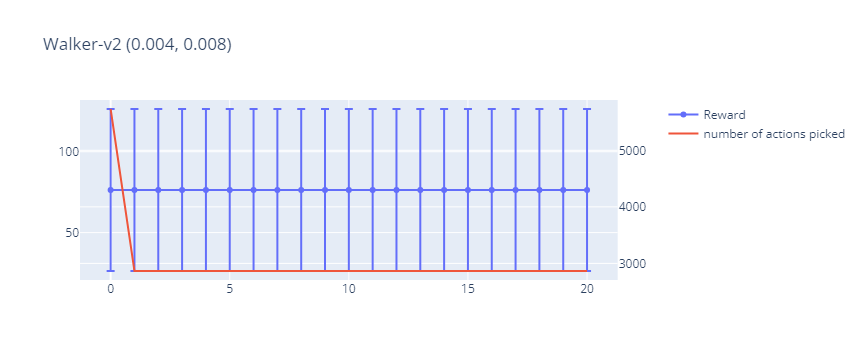

In [21]:
dataf = dataframe #.loc[dataframe['seed']!= 4]
dataf['result'] = dataf['result'] * 0.004 
df = dataf.groupby(['threshold']).mean()
df_std =  dataf.groupby(['threshold']).std()
fig = make_subplots(specs=[[{"secondary_y": True}]])


x = list(range(21))

y1_upper = list(df['result'] + df_std['result'])
y1_lower = list(df['result'] - df_std['result'])
y1_lower = y1_lower[::-1]
x_rev = x[::-1]
fig.add_trace(go.Scatter(x=x, y=df['result'], mode='lines+markers', name='Reward', error_y=dict(
            type='data', # value of error bar given in data coordinates
            array=df_std['result'],
            visible=True)), secondary_y=False)

fig.add_trace(go.Scatter(x=list(range(21)), y=df['actions'], mode='lines', name='number of actions picked'), secondary_y=True)
fig.update_layout(
    title_text="Walker-v2 (0.004, 0.008)")


In [19]:
dataf

,env,result,seed,actions,threshold
0,Hopper-v2,0.386306,0,3545.1,2.0
1,Hopper-v2,0.178967,1,1655.4,2.0
2,Hopper-v2,0.622898,2,5694.1,2.0
3,Hopper-v2,0.175919,3,1813.0,2.0
4,Hopper-v2,0.162785,4,1619.6,2.0


In [51]:
dataframe['result'] = dataframe['result']*0.004

In [52]:
dataframe['result']

0     96.576571
1     44.741662
2    155.724532
3     43.979693
4     40.696350
Name: result, dtype: float64

In [1]:
policy_name = 'TD3'
env_name = 'Hopper-v2'
jit_duration = 0.004
response_rate = 0.004
parent_response_rate = 0.008
# lcs1 = np.zeros([5, 201])
# lcs2 = np.zeros([5, 201])
lcs1 = np.zeros([201])
lcs2 = np.zeros([201])
for seed in range(5):
    arguments = ["reflex_train", policy_name, env_name, seed,jit_duration, response_rate, parent_response_rate]
    file_name = '_'.join([str(x) for x in arguments])
    lc = np.load(f"../hybrid/results_paper/{file_name}.npy")
    lcs1 += lc
    
    arguments = ["perturbation", policy_name, env_name, seed, response_rate, delayed_env]

    file_name = '_'.join([str(x) for x in arguments])
    lc = np.load(f"../hybrid/results_paper/{file_name}.npy")
    if seed != 1:
        lcs2 += lc


NameError: name 'np' is not defined

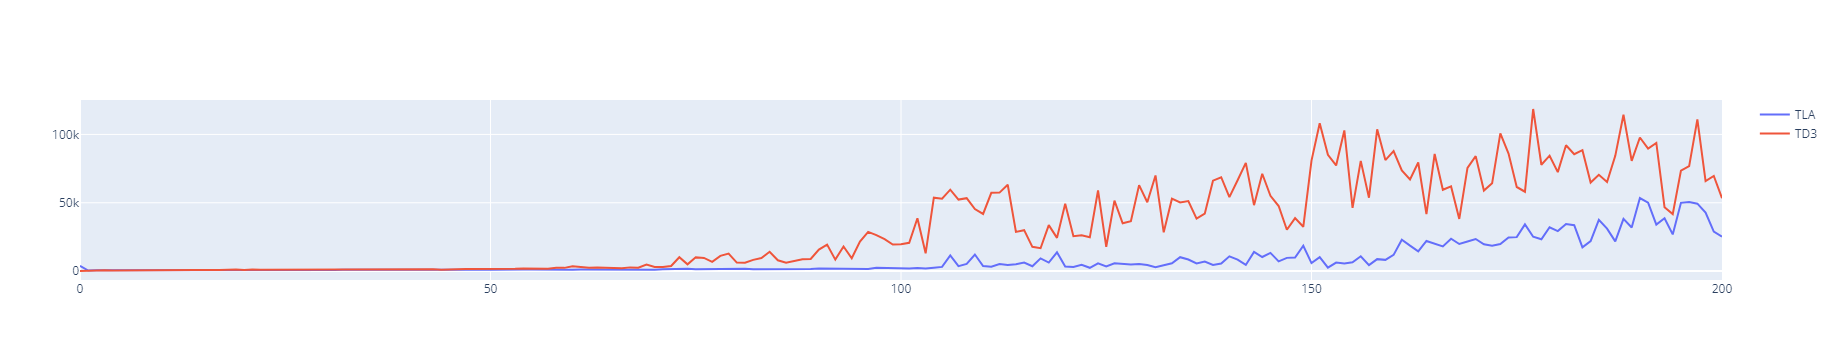

In [113]:
lcs1 /= 5
lcs2 /= 4

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(201)), y=lcs1,
                    mode='lines',
                    name='TLA'))

fig.add_trace(go.Scatter(x=list(range(201)), y=lcs2,
                    mode='lines',
                    name='TD3'))


fig.show()

In [109]:
lcs2 = lcs2[[0,2,3,4],:]
lcs2.shape

(4, 201)

In [110]:

lcs1_mean = np.mean(lcs2, 0)

for i in lcs1_mean:
    print(i)

74.48441546015488
373.184480334026
432.3773926114675
545.7604906644568
504.11627812719377
480.6004753830993
461.2597005061948
529.4697151452492
629.1645297088667
585.9951470085293
723.9998015758326
759.024027202404
799.0078633422477
710.5559402123084
794.9849382778384
870.015818473423
754.8071912300593
888.0648069366858
1075.217227245062
1198.5104314335806
759.3147961599041
1164.4133065846422
901.1192116098678
907.3391202746059
982.4338473778307
997.1981864087313
1024.760432320569
1018.7235396734857
1038.9121974247068
1069.926624296308
1302.597770598727
1163.9511877780262
1041.7002588576756
1272.7702840492502
1077.5984813000086
1258.4422302924415
1156.3207112282503
1390.116502878141
1562.306703200823
1194.496234195255
1193.1719826908127
1229.3044423626322
1330.0078818038032
1299.696582558785
1035.6435101376953
1478.636690219993
1395.8773929446616
1470.7388212353428
1486.9823446112596
1229.108031037598
1465.0051752071686
1181.801151280412
1637.5904837938633
1662.0027337967276
1907.11252